![cropped-SummerWorkshop_Header.png](attachment:02a8fa98-5280-4e58-972b-b49e606371b3.png)

<h1 align="center">Day 1 Workshop 2: Science Quest</h1>  
<h2 align="center"> How do cell-cell interactions change after learning? </h4>   
<h3 align="center"> Exploring the BCI learning dataset </h3> 
<h2 align="center"> SWDB 2025</h2> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h2>Goal</h2>
    
In this workshop, we will use our data access skills and dataset knowledge to ask a specific question - How do cell-cell interactions change after learning? 
    
More specifically, how do neuronal correlations change after a mouse learns a Brain Computer Interface (BCI) task? 
    
</div>

discuss / expand on which datasets have learning & why you would select one or another (reference dataset table)

walk through properties of this dataset and why it is suitable for the question

include somes schematics or visuals for the experiment 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Outline: 
    
    1. Accessing the BCI data
        Metadata table
    
    2. What are the conditions in this dataset? 
        Intervals, Epochs and Trials
            
    3. Quantifying activity correlations before and after BCI learning
        Cell activity traces, selecting time periods of interest, computing correlations

    4. Do correlations depend on distance between neurons?
        Segmented ROI masks and spatial relationships

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>BCI dataset overview </h2> 
    
**Overview:** In this notebook, we will analyze neural activity and connectivity changes 
during learning using a dataset from the [Credit Assignment During Learning](https://www.allenneuraldynamics.org/projects/credit-assignment-during-learning) 
project at the Allen Institute for Neural Dynamics. This dataset provides a unique window 
into how cortical circuits adapt as mice learn to volitionally control a brain-computer interface (BCI) 
using single neurons in motor cortex. This tutorial focuses on population activity and event-aligned responses
in one experimental paradigm, multi-day learning, longitudinal connectivity mapping, 
and causal perturbations across many animals.
 
**Dataset:** 
Neural activity was recorded from layer 2/3 excitatory neurons in the primary motor cortex 
of head-fixed mice using two-photon calcium imaging. Imaging was performed over multiple days
 as each animal learned and performed a BCI task. Each day, a new conditioned neuron (CN) was selected, 
 the activity of this neuron was mapped in real-time to the position of a motorized reward port. 
 To receive water rewards, mice had to learn to increase the activity of the CN to move the port into reach.
The dataset also includes simultaneous photostimulation and calcium imaging sessions, in which individual or 
groups of neurons were optogenetically stimulated to assess their causal influence on the surrounding network. 
These connection mapping sessions were repeated daily to measure how connectivity changed as learning progressed.
 Imaging data were preprocessed using Suite2p and include motion-corrected fluorescence traces, 
 extracted ROIs, inferred spiking events, and stimulus-aligned behavioral metadata. 
 All data are registered across days to track the same neurons longitudinally.

 **Experiment:**
 This experiment was designed to test competing models of learning rules—such as Hebbian learning, 
 long-range input modulation, and biologically plausible approximations of error backpropagation—by 
 directly measuring changes in neural activity and inferred connectivity during learning. 
 The core task involved a closed-loop BCI paradigm in which a single neuron’s activity controlled 
 a reward mechanism. Because the mapping from activity to behavior was fully defined by the experimenter,
  this paradigm enables ground-truth labeling of neurons as behaviorally causal (e.g., the CN) versus merely correlated.
To probe learning-related circuit changes, cellular-resolution two-photon photostimulation
 was used to perturb neurons before and after learning. By analyzing evoked responses, 
 researchers could infer the presence and strength of functional connections. 
 Learning-induced changes in connectivity were then compared to predictions 
 from recurrent neural network models trained with different plasticity rules, 
 enabling discrimination between competing learning algorithms.
    
**Goal:** This tutorial will show you how to: <br> 
    1. Load and explore calcium imaging data processed with Suite2p <br> 
    2. Align neural activity to behavioral events in the BCI task <br>
    3. Visualize trial-averaged activity of the conditioned neuron and surrounding population <br> 
    4. Prepare data for analyses of population-level changes during learning <br> 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data

In [41]:
# General imports 
import os 
import re
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats 
from skimage import measure
import matplotlib.pyplot as plt

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Accessing the BCI data</h2>   


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Metadata

The 'metadata.csv' in the '/data' folder contains relevant information about the experimental session and the subject. 

| Column    | Description |
| -------- | ------- |
| id | data asset id |
| name | filename of data asset (raw) |
| subject_id| numerical id for animal subject  |
| session_time |  experiment date (%Y-%m-%d %H:%M:%S)   |
| session_type   |  experiment identifier  |
| genotype  | subject genotype   |
| virus   | injected virus type  |
| ophys_fov   | field of view identifier  |
| session_number    | behavior training session number   |

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Load the metadata csv file as a pandas dataframe. What are the column values? 

</div>

In [91]:
metadata = pd.read_csv('/data/metadata.csv')
metadata.head()

,_id,name,subject_id,session_time,session_type,genotype,virus_injection_materials,ophys_fov,session_number
0,97679401-4b42-4cf9-9460-7b78a86d141c,single-plane-ophys_767715_2025-01-31_18-15-21_...,767715,2025-01-31T18:15:21.158999-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_01,2.0
1,21e64498-ae4b-4c84-b22f-ba454068311b,single-plane-ophys_740369_2025-02-03_19-18-31_...,740369,2025-02-03T19:18:31.580999-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_06,27.0
2,069e10c0-6d10-4101-bc33-f3febf0a6565,single-plane-ophys_740369_2025-01-09_17-18-37_...,740369,2025-01-09T16:01:04.455000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_05,22.0
3,6fcad999-aa85-439b-a51c-4cf844ca11d2,single-plane-ophys_740369_2025-01-24_21-18-11_...,740369,2025-01-24T20:08:49.286000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_05,25.0
4,b46c42e9-b7cc-4a1e-832d-9721816c9bc5,single-plane-ophys_731015_2025-01-28_18-56-35_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,22.0


In [93]:
metadata.columns

Index(['_id', 'name', 'subject_id', 'session_time', 'session_type', 'genotype',
       'virus_injection_materials', 'ophys_fov', 'session_number'],
      dtype='object')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

What are the unique values for `genotype`?

</div>

In [94]:
metadata.genotype.unique()

array(['Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-ICL-ChRmine-oScarlet-IRES2-tTA2-WPRE)-hyg/wt'],
      dtype=object)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Sort the dataframe by `subject_id` and `session_time` to group experiments from the same mice and put them in chronological order. 

</div>

In [92]:
# Sort values by name and reindex 
metadata = metadata.sort_values(by = ['subject_id', 'session_time']).reset_index(drop = True)
metadata.head()

,_id,name,subject_id,session_time,session_type,genotype,virus_injection_materials,ophys_fov,session_number
0,4fcfc173-452d-4d5b-b441-7b26da3d781b,single-plane-ophys_731015_2025-01-24_20-00-44_...,731015,2025-01-24T18:41:22.550000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,20.0
1,b46c42e9-b7cc-4a1e-832d-9721816c9bc5,single-plane-ophys_731015_2025-01-28_18-56-35_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,22.0
2,1f1039a9-72a2-4dd0-880b-2fe06c64e96a,single-plane-ophys_731015_2025-01-28_17-40-57_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,22.0
3,b2497fb0-0e67-4c9a-b543-76ccc2c7fdbd,single-plane-ophys_731015_2025-01-31_20-37-19_...,731015,2025-01-31T20:37:19.623000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,23.0
4,069e10c0-6d10-4101-bc33-f3febf0a6565,single-plane-ophys_740369_2025-01-09_17-18-37_...,740369,2025-01-09T16:01:04.455000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_05,22.0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Select a mouse and session to look at


In [43]:
subject_id = '731015'
date = metadata.session_time[3][0:10] # save just the year, month, and date
print(subject_id, date)

731015 2025-01-31


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Load the NWB file for one session using pynwb and examine its contents

</div>

In [44]:
data_folder = [folder for folder in os.listdir(r'/data/') if subject_id in folder and date in folder][0]
data_dir = os.path.join(r'/data/', data_folder)
nwb_file = [file for file in os.listdir(data_dir) if 'nwb' in file][0]
nwb_path = os.path.join(data_dir, nwb_file)

In [45]:
with NWBZarrIO(str(nwb_path), 'r') as io:
    nwbfile = io.read()
    print('Loaded NWB file from:', nwb_path)

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Loaded NWB file from: /data/single-plane-ophys_731015_2025-01-31_20-37-19_processed_2025-07-23_02-28-40/single-plane-ophys_731015_2025-01-31_20-37-19_behavior_nwb


NWB files are essentially hdf5 containers, which is a way of storing data using a directory format. There are containers (i.e. directories) for each type of data.  

The key types of data in an NWB file are: 
    * metadata (e.g. subject, imaging_planes, devices, file_create_date)
    * events (stimulus tables, intervals table)
    * processed data (cell traces, segmented ROI masks, etc)
    
The data in each container are typically provided as dynamic tables or matrices / arrays. 


In [47]:
nwbfile

root pynwb.file.NWBFile at 0x140609341765184
Fields:
  devices: {
    442_Bergamo_2p_photostim <class 'pynwb.device.Device'>
  }
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  file_create_date: [datetime.datetime(2025, 7, 22, 19, 36, 52, 330369, tzinfo=tzutc())]
  identifier: b02606e9-cd4d-467c-b780-60999e7a3115
  imaging_planes: {
    processed <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Allen Institute for Neural Dynamics
  intervals: {
    epochs <class 'pynwb.epoch.TimeIntervals'>
  }
  processing: {
    processed <class 'pynwb.base.ProcessingModule'>
  }
  session_description: NWB file generated by AIND pipeline
  session_id: single-plane-ophys_731015_2025-01-31_20-37-19
  session_start_time: 2025-01-31 20:37:19-08:00
  stimulus: {
    PhotostimTrials <class 'hdmf.common.table.DynamicTable'>,
    Trials <class 'hdmf.common.table.DynamicTable'>
  }
  subject: subject pynwb.file.Subject at 0x140609340496416
Fields:
  age: P323D
  age__reference: birth
  date_of_birth: 2024-03-14 00:00:00-07:53
  genotype: Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-ICL-ChRmine-oScarlet-IRES2-tTA2-WPRE)-hyg/wt
  sex: F
  species: Mus musculus
  subject_id: 731015

  timestamps_reference_time: 2025-01-31 20:37:19-08:00

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

`nwb2widget` creates an interactive widget to easily explore the hierarchical contents of the NWB file. The widget can also render interactive data plots (e.g. calcium activity traces, image segmentation masks). 

In [46]:
nwb2widget(nwbfile) 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Finding stuff in NWB</h2>   
<h3>How to access different pieces of data</h3>   

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>What are the conditions in this dataset?</h2>   
<h3>Explore the epochs table and trials table</h3>   

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Epoch Table 
    
The epochs table contains the start and stop times/frames for each experimental epoch, so we can easily pull these values for later use. 


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Load the epochs table from the intervals container of the NWB file. What epochs are present?

</div>

In [48]:
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,photostim,0,84794,0.000000,1455.356193
1,spont,84795,90794,1455.373356,1558.336795
2,spont_again,90795,98594,1558.353958,1692.211577
3,BCI,98595,160009,1692.228741,2746.303855
4,spontpost,160010,175538,2746.321018,3012.834816
5,photostim_post,175539,249369,3012.851979,4280.028285


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** What types of stimulus tables are available? Does every epoch have a stimulus table? 
    
Hint: check the keys of the `stimulus` container.

</div>

In [81]:
nwbfile.stimulus.keys()

dict_keys(['PhotostimTrials', 'Trials'])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** What stimuli are delivered during the photostim epoch? 
    
Load the `PhotostimTrials` table from the stimulus container and turn it into a dataframe, then check the columns. 

</div>

In [82]:
photostim = nwbfile.stimulus["PhotostimTrials"].to_dataframe()
photostim.head()


,start_time,stop_time,start_frame,stop_frame,tiff_file,stimulus_name,laser_x,laser_y,power,duration,stimulus_function,group_index,closest_roi
id,,,,,,,,,,,,,
0,0.000000,0.617884,0,36,spont_slm_00001.tif,photostim,241.425926,212.703704,4,0.617884,scanimage.mroi.stimulusfunctions.logspiral,78,421
1,0.635047,1.218604,37,71,spont_slm_00002.tif,photostim,168.200000,149.975000,4,0.583557,scanimage.mroi.stimulusfunctions.logspiral,55,355
2,1.235767,1.836487,72,107,spont_slm_00003.tif,photostim,165.013514,133.905405,4,0.600720,scanimage.mroi.stimulusfunctions.logspiral,8,153
3,1.853651,2.454371,108,143,spont_slm_00004.tif,photostim,239.032258,40.870968,4,0.600720,scanimage.mroi.stimulusfunctions.logspiral,65,1169
4,2.471534,3.089418,144,180,spont_slm_00005.tif,photostim,57.355556,112.800000,4,0.617884,scanimage.mroi.stimulusfunctions.logspiral,15,85


In [83]:
photostim.columns


Index(['start_time', 'stop_time', 'start_frame', 'stop_frame', 'tiff_file',
       'stimulus_name', 'laser_x', 'laser_y', 'power', 'duration',
       'stimulus_function', 'group_index', 'closest_roi'],
      dtype='object')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
What are the values of the `stimulus_name` column? 

</div>

In [85]:
photostim.stimulus_name.unique()

array(['photostim', 'photostim_post'], dtype=object)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** What happens during the BCI task epoch? 
    
Load the `Trials` table from the stimulus container, turn it into a dataframe, then check the columns. 

</div>

In [87]:
trials = nwbfile.stimulus["Trials"].to_dataframe()
trials.head()


,start_time,stop_time,go_cue,hit,lick_L,reward_time,threshold_crossing_times,zaber_step_times,tiff_file,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y,closest_roi
id,,,,,,,,,,,,,,
0,1692.228741,1704.020019,0.2359,True,"[1.7861, 1.9033, 2.0241, 2.1415, 2.2464, 2.375...",1.7861,1.7089,"[0.3535, 0.5054000000000001, 0.6074, 0.7184, 0...",neuron119_00001.tif,98595,99282,108.633333,51.666667,124
1,1704.037183,1708.722800,0.2359,True,"[1.0667, 1.2012, 1.3251000000000002, 1.4520000...",1.0667,1.0582,"[0.2869, 0.3589, 0.4188, 0.4969, 0.5359, 0.577...",neuron119_00002.tif,99283,99556,108.633333,51.666667,124
2,1708.739964,1714.060628,0.2359,True,"[0.7160000000000001, 0.8175, 0.9416, 1.0605, 1...",0.8175,0.7399,"[0.3182, 0.3502, 0.3822, 0.4142, 0.4462, 0.478...",neuron119_00003.tif,99557,99867,108.633333,51.666667,124
3,1714.077792,1718.488794,0.2359,True,"[1.0345, 1.1526, 1.2687000000000002, 1.392, 1....",1.0345,0.9577,"[0.4984, 0.5503, 0.5874, 0.6204000000000001, 0...",neuron119_00004.tif,99868,100125,108.633333,51.666667,124
4,1718.505957,1725.869070,0.2359,True,"[1.3371, 1.4519, 1.5667, 1.6952, 1.8063, 1.932...",1.3371,1.3072,"[0.8276, 0.8886000000000001, 0.9356, 0.9736, 1...",neuron119_00005.tif,100126,100555,108.633333,51.666667,124


In [88]:
trials.columns

Index(['start_time', 'stop_time', 'go_cue', 'hit', 'lick_L', 'reward_time',
       'threshold_crossing_times', 'zaber_step_times', 'tiff_file',
       'start_frame', 'stop_frame', 'conditioned_neuron_x',
       'conditioned_neuron_y', 'closest_roi'],
      dtype='object')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Stimulus table (2p optogenetic activation stimulus) 
    
The stimulus table (stimulus > PhotostimTrials) contains information about each 2p optogenetic stimulation trial. 

| Column    | Description |
| -------- | ------- |
| start_time  | stimulus start (s)  |
| stop_time | stimulus end (s)   |
| start_frame | stimulus start (frame)     |
| stop_frame    | stimulus end (frame)  |
| tiff_file   | data source file name  |
| stimulus_name    | stimulus name   |
| laser_x    | x coordinate of stimulated neuron (pixel)   |
| laser_y    | y coordinate of stimulated neuron (pixel)  |
| power    | stimulus intensity (mW)  |
| duration    | trial duration (s)  |
| stimulus_function    | stimulus template   |
| group_index    | identity of stimulated neuron(s)   |
| closest_roi    | index in dff that corresponds to the photostimulated neuron   |


In [49]:
photostim = nwbfile.stimulus["PhotostimTrials"].to_dataframe()
photostim.head()


,start_time,stop_time,start_frame,stop_frame,tiff_file,stimulus_name,laser_x,laser_y,power,duration,stimulus_function,group_index,closest_roi
id,,,,,,,,,,,,,
0,0.000000,0.617884,0,36,spont_slm_00001.tif,photostim,241.425926,212.703704,4,0.617884,scanimage.mroi.stimulusfunctions.logspiral,78,421
1,0.635047,1.218604,37,71,spont_slm_00002.tif,photostim,168.200000,149.975000,4,0.583557,scanimage.mroi.stimulusfunctions.logspiral,55,355
2,1.235767,1.836487,72,107,spont_slm_00003.tif,photostim,165.013514,133.905405,4,0.600720,scanimage.mroi.stimulusfunctions.logspiral,8,153
3,1.853651,2.454371,108,143,spont_slm_00004.tif,photostim,239.032258,40.870968,4,0.600720,scanimage.mroi.stimulusfunctions.logspiral,65,1169
4,2.471534,3.089418,144,180,spont_slm_00005.tif,photostim,57.355556,112.800000,4,0.617884,scanimage.mroi.stimulusfunctions.logspiral,15,85


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There are two photostimulation epochs - one before and one after the BCI epoch. This is distinguished by the "stimulus_name" column. 

In [50]:
photostim["stimulus_name"].unique().tolist()

['photostim', 'photostim_post']

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Load the behavior trials table. What happens during this epoch? 

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### BCI Behavior Table 
    
Information about the BCI behavior trials can be found in the intervals > trials table. 

| Column    | Description |
| -------- | ------- |
| start_time  | trial start (s)  |
| stop_time | trial end (s)   |
| go_cue |  time of go cue relative to start time (s)   |
| hit   |  boolean of whether trial was hit   |
| lick_l  | lick times (s)   |
| reward_time   | reward delivery time (s)   |
| threshold_crossing_times    | time when reward port crossed position threshold (s)   |
| zaber_steps_times   | position of reward port  |
| tiff_file    | data source file  |
| start_frame    | trial start (frame)  |
| stop_frame    | trial end (frame)  |
| conditioned_neuron_x    | coordinate for conditioned neuron (pixels)  |
| conditioned_neuron_y    | coordinate for conditioned neuron (pixels)  |
| closest_roi    | index in dff that corresponds to the photostimulated neuron  |


In [51]:
bci = nwbfile.stimulus["Trials"].to_dataframe()
bci.head()

,start_time,stop_time,go_cue,hit,lick_L,reward_time,threshold_crossing_times,zaber_step_times,tiff_file,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y,closest_roi
id,,,,,,,,,,,,,,
0,1692.228741,1704.020019,0.2359,True,"[1.7861, 1.9033, 2.0241, 2.1415, 2.2464, 2.375...",1.7861,1.7089,"[0.3535, 0.5054000000000001, 0.6074, 0.7184, 0...",neuron119_00001.tif,98595,99282,108.633333,51.666667,124
1,1704.037183,1708.722800,0.2359,True,"[1.0667, 1.2012, 1.3251000000000002, 1.4520000...",1.0667,1.0582,"[0.2869, 0.3589, 0.4188, 0.4969, 0.5359, 0.577...",neuron119_00002.tif,99283,99556,108.633333,51.666667,124
2,1708.739964,1714.060628,0.2359,True,"[0.7160000000000001, 0.8175, 0.9416, 1.0605, 1...",0.8175,0.7399,"[0.3182, 0.3502, 0.3822, 0.4142, 0.4462, 0.478...",neuron119_00003.tif,99557,99867,108.633333,51.666667,124
3,1714.077792,1718.488794,0.2359,True,"[1.0345, 1.1526, 1.2687000000000002, 1.392, 1....",1.0345,0.9577,"[0.4984, 0.5503, 0.5874, 0.6204000000000001, 0...",neuron119_00004.tif,99868,100125,108.633333,51.666667,124
4,1718.505957,1725.869070,0.2359,True,"[1.3371, 1.4519, 1.5667, 1.6952, 1.8063, 1.932...",1.3371,1.3072,"[0.8276, 0.8886000000000001, 0.9356, 0.9736, 1...",neuron119_00005.tif,100126,100555,108.633333,51.666667,124


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Load one cell's dff trace and plot the epochs 

</div>

In [52]:
dff = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data

print('dff shape (nframes, nrois):',np.shape(dff))

frame_rate = nwbfile.imaging_planes["processed"].imaging_rate
print('Frame Rate:', frame_rate)

dff shape (nframes, nrois): (249370, 1736)
Frame Rate: 58.2634


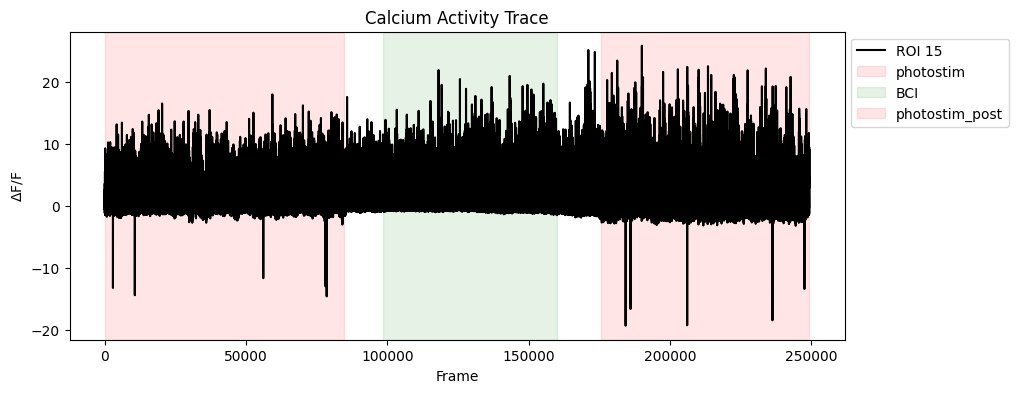

In [53]:
ROI = 15

# Plot dff for select ROI 
plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(dff[:, ROI], label=f'ROI {ROI}', color='black')

# Add shaded regions for stimulus epochs 
stimulus_names = ['photostim','BCI','photostim_post']
colors = ['red','green','red']
for c,stimulus_name in enumerate(stimulus_names):
    stim = epoch_table[epoch_table.stimulus_name==stimulus_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start_frame.iloc[j], xmax=stim.stop_frame.iloc[j], color=colors[c], alpha=0.1, label = stimulus_name)

plt.ylabel(r'$\Delta$F/F')
plt.xlabel('Frame')
plt.title('Calcium Activity Trace')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [54]:
# use photostim artifact as a group question / discussion - why are they there, how do you find them and deal with it

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Quantifying activity correlations</h2>   
<h3>Extract cell activity traces for spontaneous activity epochs and quantify correlations</h3>   

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Extract the dFF traces for the spontaneous activity epochs before and after the BCI task

</div>

In [55]:
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,photostim,0,84794,0.000000,1455.356193
1,spont,84795,90794,1455.373356,1558.336795
2,spont_again,90795,98594,1558.353958,1692.211577
3,BCI,98595,160009,1692.228741,2746.303855
4,spontpost,160010,175538,2746.321018,3012.834816
5,photostim_post,175539,249369,3012.851979,4280.028285


In [56]:
spontaneous_pre = epoch_table[epoch_table.stimulus_name=='spont']
spontaneous_post = epoch_table[epoch_table.stimulus_name=='spontpost']

In [57]:
spontaneous_pre.start_frame.values[0]

np.int64(84795)

In [58]:
dff_pre = dff[spontaneous_pre.start_frame.values[0]:spontaneous_pre.stop_frame.values[0], :]
dff_pre.shape

(5999, 1736)

In [59]:
dff_post = dff[spontaneous_post.start_frame.values[0]:spontaneous_post.stop_frame.values[0], :]
dff_post.shape

(15528, 1736)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Visualize the dFF traces for each spontaneous period as a heatmap

</div>

Text(0.5, 1.0, 'Spontaneous pre')

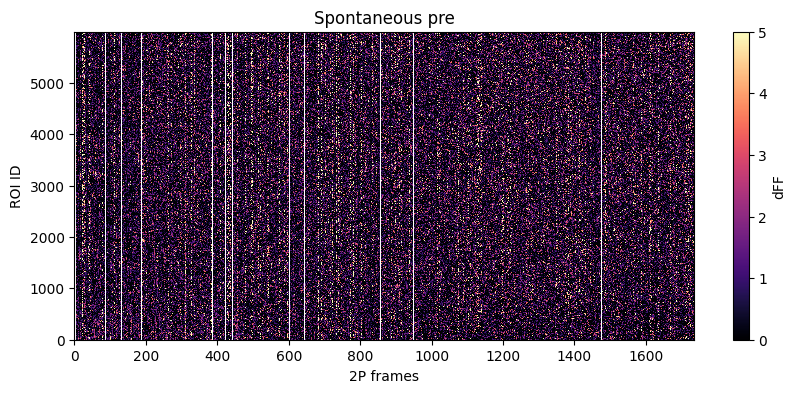

In [60]:
plt.pcolormesh(dff_pre, vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Spontaneous pre')

Text(0.5, 1.0, 'Spontaneous post')

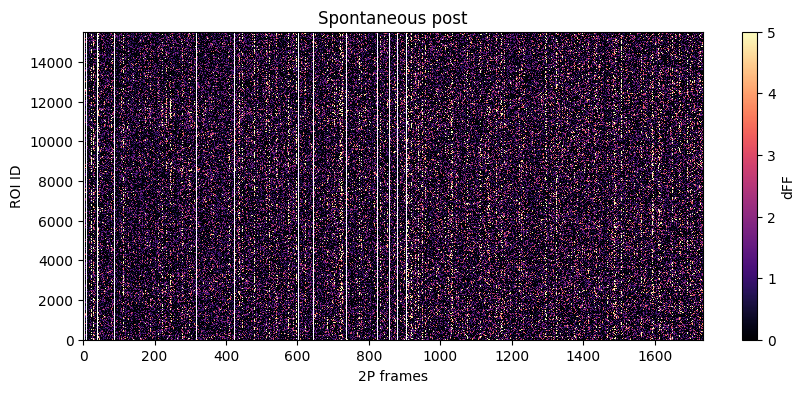

In [61]:
plt.pcolormesh(dff_post, vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Spontaneous post')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Woah thats a lot of ROIs. Are they all valid? 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Load the ROI masks table to identify valid soma ROIs, then limit dFF traces array to valid ROIs and look at the heatmap again

</div>

In [62]:
image_segmentation = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()
image_segmentation.head()

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
0,0,0.000019,0,0.144048,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,0.000021,0,0.000081,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0.219488,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0.000000,0,0.000002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,0.999860,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [63]:
valid_rois = image_segmentation[image_segmentation.is_soma==True].index.values

In [64]:
dff_pre = dff_pre[:, valid_rois]
dff_post = dff_post[:, valid_rois]

Text(0.5, 1.0, 'Spontaneous pre')

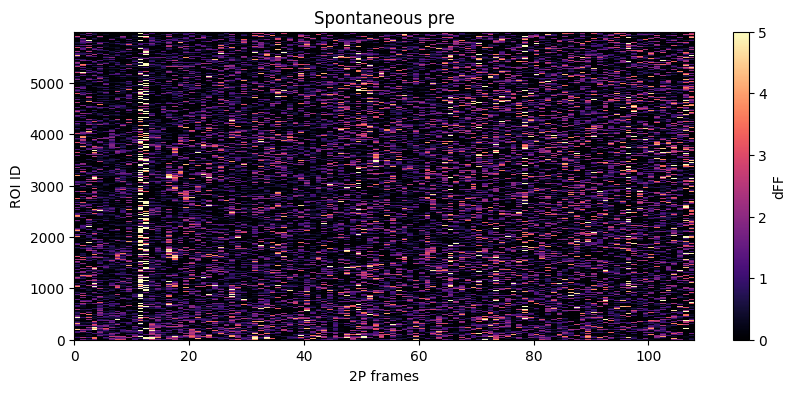

In [65]:
plt.pcolormesh(dff_pre, vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Spontaneous pre')

Text(0.5, 1.0, 'Spontaneous post')

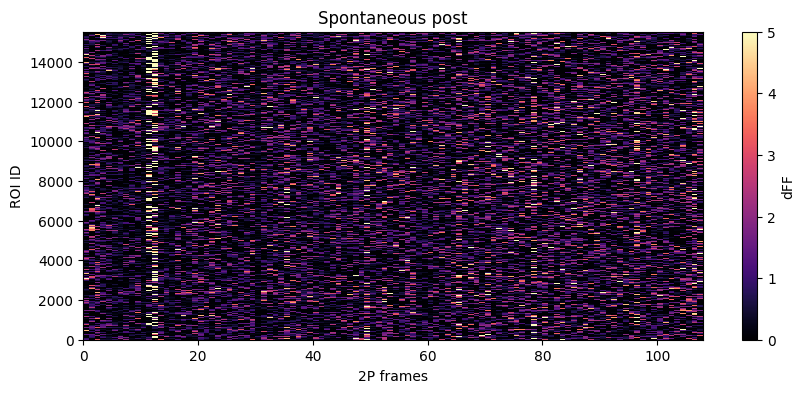

In [66]:
plt.pcolormesh(dff_post, vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Spontaneous post')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Quantify the correlation between every cell pair's dff traces and plot as a heatmap

</div>

In [67]:
correlations_pre = np.corrcoef(dff_pre.T)
correlations_post = np.corrcoef(dff_post.T)

correlations_pre.shape

(108, 108)

(np.float64(0.0), np.float64(108.0), np.float64(0.0), np.float64(108.0))

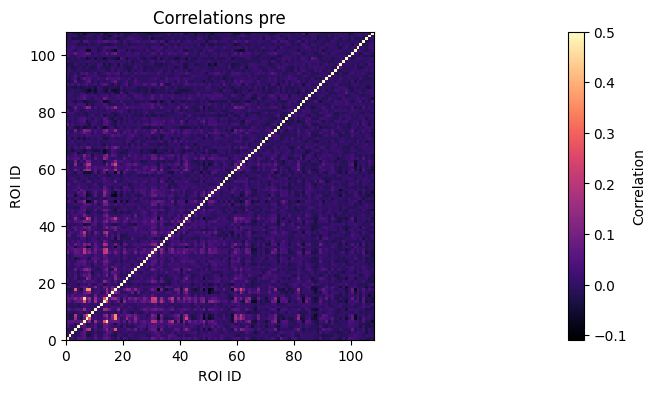

In [68]:
plt.pcolormesh(correlations_pre, cmap='magma', vmax=0.5)
plt.colorbar(label='Correlation')
plt.xlabel('ROI ID')
plt.ylabel('ROI ID')
plt.title('Correlations pre')
plt.axis('square')

(np.float64(0.0), np.float64(108.0), np.float64(0.0), np.float64(108.0))

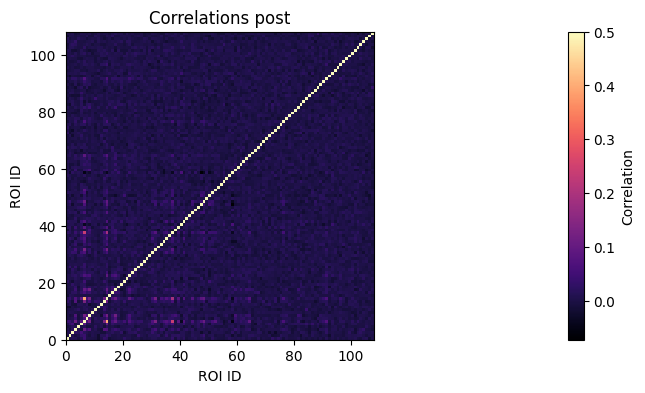

In [69]:
plt.pcolormesh(correlations_post, cmap='magma', vmax=0.5)
plt.colorbar(label='Correlation')
plt.xlabel('ROI ID')
plt.ylabel('ROI ID')
plt.title('Correlations post')
plt.axis('square')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Correlations as a function of distance</h2>   
<h3>Load the segmented ROI masks and compute cell-cell distances</h3>   

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Image Segmentation Table 
    
Each column in dff contains change in fluorescence activity for an extracted ROI. The raw fluorescence data is run through suite2p, which segments the image to extract image masks for each detected ROI. The suite2p outputs are run through additional soma and dendrite classifiers. Information about the spatial image masks and soma/dendrite can be found in the image segmentation table within the processing container. 
    
We'll store the image segmentation table as a Pandas DataFrame. 

| Column    | Description |
| -------- | ------- |
| is_soma  | ==1 if ROI classified as soma, ==0 if not  |
| soma_probability | if >0.5 classified as soma  |
| is_dendrite |  ==1 if ROI classified as dendrite, ==0 if not   |
| dendrite_probability   |  if >0.5 classified as dendrite  |
| image_mask  | HxW sparse array defining image masks|

In [70]:
image_segmentation = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()
image_segmentation.head()

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
0,0,0.000019,0,0.144048,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,0.000021,0,0.000081,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0.219488,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0.000000,0,0.000002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,0.999860,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### ROI Image Masks 
    
The image masks for each ROI are necessary for corresponding the ROIs to the photostimulated and conditioned neurons. If you recall, the photostim and bci tables report the centroid coordinates in pixel space for the photostimulated and conditioned neurons in each trial. 

Text(0.5, 1.0, 'ROI Image Mask')

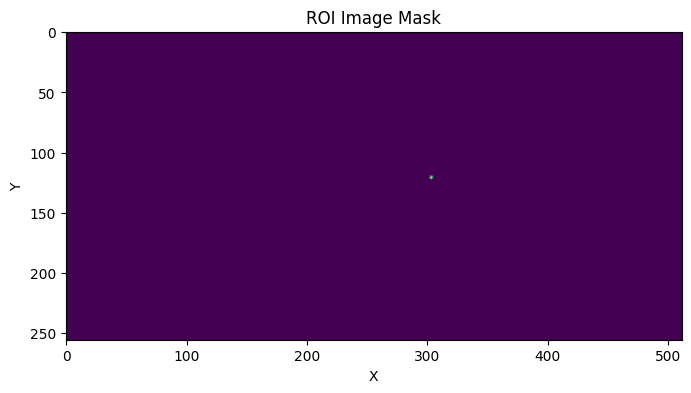

In [71]:
# Plot the image mask for selected ROI 
plt.imshow(image_segmentation.image_mask[ROI])
plt.xlabel('X') 
plt.ylabel('Y') 
plt.title('ROI Image Mask') 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot ROI DFF and Image Masks 
    
Building on our DFF frameseries plot, we'll add a plot indicating the spatial location of the selected ROI. Using image mask, we'll identify the contours of the ROI and overlay this with the average projection of the FOV image. 

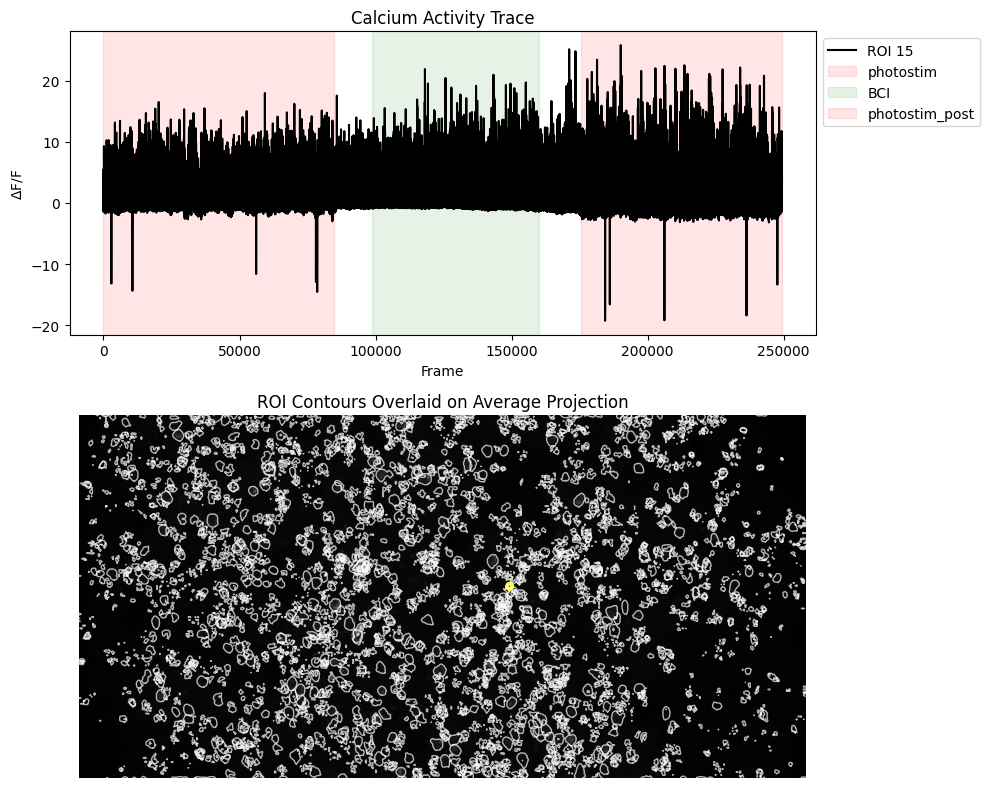

In [72]:
# FOV image data to underlay with image mask contours 
image = nwbfile.processing["processed"].data_interfaces["images"].images["average_projection"].data[:]  # shape: (H, W)

# Figure parameters for vertically stacked plots 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[1, 1.2])

# Top Plot: ROI DFF 
ax1.plot(dff[:, ROI], label=f'ROI {ROI}', color='black')

# Top Plot: Shaded regions for stimulus epochs 
stimulus_names = ['photostim','BCI','photostim_post']
colors = ['red','green','red']
for c,stimulus_name in enumerate(stimulus_names):
    stim = epoch_table[epoch_table.stimulus_name==stimulus_name]
    for j in range(len(stim)):
        ax1.axvspan(xmin=stim.start_frame.iloc[j], xmax=stim.stop_frame.iloc[j], color=colors[c], alpha=0.1, label = stimulus_name)

ax1.set_ylabel(r'$\Delta$F/F')
ax1.set_xlabel('Frame')
ax1.set_title('Calcium Activity Trace')
ax1.legend(bbox_to_anchor=(1.0, 1.0))

# Bottom plot: Grayscale image with ROI contours 
# Ensure proper display of the background image
ax2.imshow(image, cmap='gray', origin='upper', aspect='equal')
ax2.set_title('ROI Contours Overlaid on Average Projection')
ax2.axis('off')

# Overlay ROI contours
for i, mask in enumerate(image_segmentation.image_mask):
    mask_array = np.array(mask)
    # Find contours at a level that works well for binary masks
    contours = measure.find_contours(mask_array, level=0.5)
    
    for contour in contours:
        # Highlight the selected ROI
        if i == ROI:
            color = 'yellow'
            linewidth = 2.5
            alpha = 1.0
        else:
            color = 'white'
            linewidth = 1.0
            alpha = 0.7
        
        # Plot contour (note: contour coordinates are in (row, col) format)
        ax2.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth, alpha=alpha)

# Set the axis limits to match the image dimensions
ax2.set_xlim(0, image.shape[1])
ax2.set_ylim(image.shape[0], 0)  # Flip y-axis to match image coordinates

plt.tight_layout()
plt.show()

In [73]:
# segmemtation discussion opportunity - how to filter / clean ; diff segmentation methods 

In [74]:
# filter out non-cells, also need to filter dFF (make sure indexing doesnt give you problems)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Calculate the centroid of each ROI image mask 

The ROI image masks are represented as a HxW sparse array with non-zero values that span the ROI area. We can find the centroid of the ROI by calculating the mean of the x,y indices of each mask. We've pre-written the function `get_roi_centroids` to do this. 

In [75]:
def get_roi_centroids(image_segmentation):
    centroids = []
    for mask in image_segmentation['image_mask']:
        ys, xs = np.where(mask)
        x = np.mean(xs)
        y = np.mean(ys)
        centroids.append((x, y))
    return np.array(centroids)

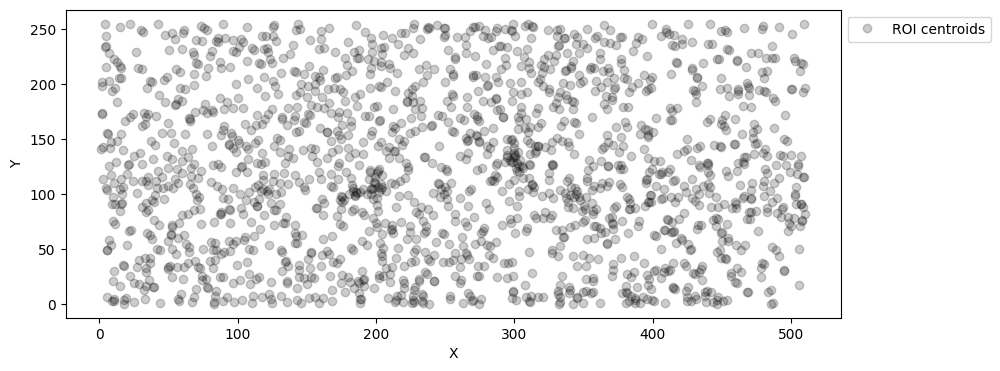

In [76]:
# Calculate centroids for each ROI and plot 

centroids = get_roi_centroids(image_segmentation)
centroidX = centroids[:, 0]
centroidY = centroids[:, 1]

plt.plot(centroidX, centroidY, 'ko', alpha = 0.2, label = 'ROI centroids')
plt.xlabel('X') 
plt.ylabel('Y')
plt.legend()
plt.legend(bbox_to_anchor=(1.0, 1.0))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We'll calculate the Euclidean distance between each ROI centroid and the conditioned neuron coordinate. The ROI with the minimum distance is our `closest_roi`, in other words, the index in dff that will give us the neural activity trace for the conditioned neuron. 

In [77]:
# Grab the conditioned neuron coordinate 
x = bci['conditioned_neuron_x'].iloc[0]
y = bci['conditioned_neuron_y'].iloc[0]
conditioned_coord = np.array([x, y])
print("Conditioned neuron coordinate:", conditioned_coord)

# Calculate the ROI centroid coordinates 
centroids = get_roi_centroids(image_segmentation)
# Reshape into an array of shape: nROIs, 2 
roi_coords = np.stack((centroids[:, 0], centroids[:, 1]), axis=1)
# Calculate euclidean distance between each ROI coord and conditioned neuron coord, find min 
conditioned_neuron = np.argmin(np.linalg.norm(roi_coords - conditioned_coord, axis=1))
print(f"Closest ROI is #{conditioned_neuron} at {centroids[conditioned_neuron]}")
    

print('Conditioned neuron coordinates:', bci.conditioned_neuron_x[0], bci.conditioned_neuron_y[0])

Conditioned neuron coordinate: [108.63333333  51.66666667]
Closest ROI is #124 at [108.38235294  50.44117647]
Conditioned neuron coordinates: 108.63333333333333 51.666666666666664


End with idea of - what other datasets could you apply this analysis to? 

Add demo of saving processed data (correlations) for comparison across sessions or datasets 
Use same format as day 4 workshop correlations that will be loaded for their notebooks

table with columns for cell 1 ID, cell 2 ID, and stimulus condition with r_val in the col for the relevant stimulus condition 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; ">

#### Questions and analyses to explore further:
 
* How does connectivity change across the photostimulation periods? Does it change with the BCI task? 
    
* How does connection strength depend on distance? 
    
* Do correlated neurons tend to have stronger connections? 
    
* Quantify the degree to which the conditioned neuron increases its activity throughout the task. 
    
* Do differences in the transgenic lines or injected viruses impact connectivity and photostimulation measurements? 
    
* Do non-conditioned neurons change activity during the BCI task? 
    